# Рейтинги валют Forex по абсолютному курсу

# Меню проекта

[Источник котировок](https://www.kaggle.com/code/eavprog/abscur2)

**Рейтинги валют Forex по абсолютному курсу**



# Оглавление

[Лидеры роста и падения](#Лидеры-роста-и-падения)

[Лидеры доходности](#Лидеры-доходности)

[Лидеры волатильности](#Лидеры-волатильности)

[Лидеры по коэффициенту Шарпа](#Лидеры-по-коэффициенту-Шарпа)

[Лидеры по коэффициенту Сортино](#Лидеры-по-коэффициенту-Сортино)

In [1]:
import pandas as pd

all_abscur = pd.read_csv("/kaggle/input/abscur2/abscur.csv",index_col='Date')
all_abscur.index = pd.to_datetime(all_abscur.index)
# all_abscur

In [2]:
# Формируем словарь для расшифровок валют
cur_descr = """AED	Дирхам ОАЭ	https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%80%D1%85%D0%B0%D0%BC_%D0%9E%D0%90%D0%AD
ARS	Аргентинское песо	https://ru.wikipedia.org/wiki/%D0%90%D1%80%D0%B3%D0%B5%D0%BD%D1%82%D0%B8%D0%BD%D1%81%D0%BA%D0%BE%D0%B5_%D0%BF%D0%B5%D1%81%D0%BE
AUD	Австралийский доллар	https://ru.wikipedia.org/wiki/%D0%90%D0%B2%D1%81%D1%82%D1%80%D0%B0%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
BRL	Бразильский реал	https://ru.wikipedia.org/wiki/%D0%91%D1%80%D0%B0%D0%B7%D0%B8%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D0%B5%D0%B0%D0%BB
CAD	Канадский доллар	https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%BD%D0%B0%D0%B4%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
CHF	Швейцарский франк	https://ru.wikipedia.org/wiki/%D0%A8%D0%B2%D0%B5%D0%B9%D1%86%D0%B0%D1%80%D1%81%D0%BA%D0%B8%D0%B9_%D1%84%D1%80%D0%B0%D0%BD%D0%BA
CLP	Чилийское песо	https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B5_%D0%BF%D0%B5%D1%81%D0%BE
CNY	Китайский юань	https://ru.wikipedia.org/wiki/%D0%9A%D0%B8%D1%82%D0%B0%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D1%8E%D0%B0%D0%BD%D1%8C
COP	Колумбийское песо	https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D1%83%D0%BC%D0%B1%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B5_%D0%BF%D0%B5%D1%81%D0%BE
CZK	Чешская крона	https://ru.wikipedia.org/wiki/%D0%A7%D0%B5%D1%88%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D1%80%D0%BE%D0%BD%D0%B0
DKK	Датская крона	https://ru.wikipedia.org/wiki/%D0%94%D0%B0%D1%82%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D1%80%D0%BE%D0%BD%D0%B0
EGP	Египетский фунт	https://ru.wikipedia.org/wiki/%D0%95%D0%B3%D0%B8%D0%BF%D0%B5%D1%82%D1%81%D0%BA%D0%B8%D0%B9_%D1%84%D1%83%D0%BD%D1%82
EUR	Евро	https://ru.wikipedia.org/wiki/%D0%95%D0%B2%D1%80%D0%BE
GBP	Фунт стерлингов	https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D1%82_%D1%81%D1%82%D0%B5%D1%80%D0%BB%D0%B8%D0%BD%D0%B3%D0%BE%D0%B2
HKD	Гонконгский доллар	https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D0%BD%D0%BA%D0%BE%D0%BD%D0%B3%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
HUF	Венгерский форинт	https://ru.wikipedia.org/wiki/%D0%A4%D0%BE%D1%80%D0%B8%D0%BD%D1%82
IDR	Индонезийская рупия	https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%BE%D0%BD%D0%B5%D0%B7%D0%B8%D0%B9%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D1%83%D0%BF%D0%B8%D1%8F
ILS	Новый израильский шекель	https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B8%D0%B7%D1%80%D0%B0%D0%B8%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D1%88%D0%B5%D0%BA%D0%B5%D0%BB%D1%8C
INR	Индийская рупия	https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B8%D0%B9%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D1%83%D0%BF%D0%B8%D1%8F
ISK	Исландская крона	https://ru.wikipedia.org/wiki/%D0%98%D1%81%D0%BB%D0%B0%D0%BD%D0%B4%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D1%80%D0%BE%D0%BD%D0%B0
JPY	Японская иена	https://ru.wikipedia.org/wiki/%D0%98%D0%B5%D0%BD%D0%B0
KRW	Южнокорейская вона	https://ru.wikipedia.org/wiki/%D0%AE%D0%B6%D0%BD%D0%BE%D0%BA%D0%BE%D1%80%D0%B5%D0%B9%D1%81%D0%BA%D0%B0%D1%8F_%D0%B2%D0%BE%D0%BD%D0%B0
KWD	Кувейтский динар	https://ru.wikipedia.org/wiki/%D0%9A%D1%83%D0%B2%D0%B5%D0%B9%D1%82%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%B8%D0%BD%D0%B0%D1%80
KZT	Казахстанский тенге	https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D1%82%D0%B5%D0%BD%D0%B3%D0%B5
MXN	Мексиканское песо	https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BA%D1%81%D0%B8%D0%BA%D0%B0%D0%BD%D1%81%D0%BA%D0%BE%D0%B5_%D0%BF%D0%B5%D1%81%D0%BE
MYR	Малайзийский ринггит	https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D0%BB%D0%B0%D0%B9%D0%B7%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D0%B8%D0%BD%D0%B3%D0%B3%D0%B8%D1%82
NOK	Норвежская крона	https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%B2%D0%B5%D0%B6%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D1%80%D0%BE%D0%BD%D0%B0
NZD	Новозеландский доллар	https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D0%B2%D0%BE%D0%B7%D0%B5%D0%BB%D0%B0%D0%BD%D0%B4%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
PEN	Перуанский новый соль	https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D1%83%D0%B0%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D0%BD%D0%BE%D0%B2%D1%8B%D0%B9_%D1%81%D0%BE%D0%BB%D1%8C
PHP	Филиппинское песо	https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D0%B8%D0%BF%D0%BF%D0%B8%D0%BD%D1%81%D0%BA%D0%BE%D0%B5_%D0%BF%D0%B5%D1%81%D0%BE
PKR	Пакистанская рупия	https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D0%BA%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D1%83%D0%BF%D0%B8%D1%8F
PLN	Польский злотый	https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%B7%D0%BB%D0%BE%D1%82%D1%8B%D0%B9
QAR	Катарский риал	https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%82%D0%B0%D1%80%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D0%B8%D0%B0%D0%BB
RON	Румынский лей	https://ru.wikipedia.org/wiki/%D0%A0%D1%83%D0%BC%D1%8B%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D0%BB%D0%B5%D0%B9
RUB	Российский рубль	https://ru.wikipedia.org/wiki/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D1%83%D0%B1%D0%BB%D1%8C
SAR	Саудовский риял	https://ru.wikipedia.org/wiki/%D0%A1%D0%B0%D1%83%D0%B4%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D0%B8%D1%8F%D0%BB
SEK	Шведская крона	https://ru.wikipedia.org/wiki/%D0%A8%D0%B2%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D1%80%D0%BE%D0%BD%D0%B0
SGD	Сингапурский доллар	https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B3%D0%B0%D0%BF%D1%83%D1%80%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
THB	Тайский бат	https://ru.wikipedia.org/wiki/%D0%A2%D0%B0%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D0%B1%D0%B0%D1%82
TRY	Турецкая лира	https://ru.wikipedia.org/wiki/%D0%A2%D1%83%D1%80%D0%B5%D1%86%D0%BA%D0%B0%D1%8F_%D0%BB%D0%B8%D1%80%D0%B0
TWD	Новый тайваньский доллар	https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D0%B2%D1%8B%D0%B9_%D1%82%D0%B0%D0%B9%D0%B2%D0%B0%D0%BD%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BB%D0%BB%D0%B0%D1%80
UAH	Украинская гривна	https://ru.wikipedia.org/wiki/%D0%A3%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D1%81%D0%BA%D0%B0%D1%8F_%D0%B3%D1%80%D0%B8%D0%B2%D0%BD%D0%B0
USD	Доллар США	https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%BB%D0%BB%D0%B0%D1%80_%D0%A1%D0%A8%D0%90
VND	Вьетнамский донг	https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%BD%D0%B3
ZAR	Южноафриканский рэнд	https://ru.wikipedia.org/wiki/%D0%AE%D0%B6%D0%BD%D0%BE%D0%B0%D1%84%D1%80%D0%B8%D0%BA%D0%B0%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D1%8D%D0%BD%D0%B4"""
cur_descr = [item.split('\t') for item in cur_descr.split('\n')]
cur_descr = {item[0]: item[1:] for item in cur_descr}

In [3]:
# Получение сегодняшней даты и вычисление дат в прошлом
today = pd.Timestamp.now().normalize()

days_ago_7 = today - pd.Timedelta(days=7)
month_ago = today - pd.DateOffset(months=1)
quarter_ago = today - pd.DateOffset(months=3)
half_year_ago = today - pd.DateOffset(months=6)
year_ago = today - pd.DateOffset(years=1)
two_years_ago = today - pd.DateOffset(years=2)
three_years_ago = today - pd.DateOffset(years=3)
five_years_ago = today - pd.DateOffset(years=5)
ten_years_ago = today - pd.DateOffset(years=10)

# Создание списка диапазонов и их расшифровок
date_ranges = [
    [days_ago_7, today, "неделю"],
    [month_ago, today, "месяц"],
    [quarter_ago, today, "квартал"],
    [half_year_ago, today, "полгода"],
    [year_ago, today, "год"],
    [two_years_ago, today, "два года"],
    [three_years_ago, today, "три года"],
    [five_years_ago, today, "пять лет"],
    [ten_years_ago, today, "десять лет"]
]

ago_dates = {item[2] : item[0] for item in date_ranges}

In [4]:
import numpy as np

# Словарь для хранения относительных изменений
relative_changes = {item[2] : {} for item in date_ranges}

# Словарь для хранения доходностей
returns = {item[2] : {} for item in date_ranges}

# Словарь для хранения волатильностей
volat = {item[2] : {} for item in date_ranges}

# Словарь для хранения по коэффициенту Шарпа
sharp = {item[2] : {} for item in date_ranges}

# Словарь для хранения по коэффициенту Сортино
sortino = {item[2] : {} for item in date_ranges}

for ticker in all_abscur.columns:
    # print(ticker)
    data = all_abscur[ticker]

    # Вычисление относительных изменений для каждого диапазона
    for date_threshold, _, period in date_ranges:
        last_period_data = data.loc[data.index >= date_threshold]
        last_period_returns = data.pct_change().loc[data.index >= date_threshold]
        
        if len(last_period_data) > 1:  # Проверяем, достаточно ли данных для расчета
            relative_change = (last_period_data.iloc[-1] - last_period_data.iloc[0]) / last_period_data.iloc[0]
            relative_changes[period][ticker] = relative_change

            returns[period][ticker] = last_period_returns.mean()
            
            volat[period][ticker] = last_period_returns.std()
            
            sharp[period][ticker] = returns[period][ticker] / volat[period][ticker]

            # Расчет коэффициента Сортино
            downside_returns = last_period_returns[last_period_returns < 0]
            downside_deviation = downside_returns.std()
            
            if downside_deviation > 0:  # Проверяем, чтобы избежать деления на ноль
                sortino[period][ticker] = (returns[period][ticker]) / downside_deviation
            else:
                sortino[period][ticker] = np.nan  # Если нет негативных доходностей

# Преобразование словарей в Series
relative_changes_series = {period: pd.Series(changes) for period, changes in relative_changes.items()}
returns_series = {period: pd.Series(changes) for period, changes in returns.items()}
volat_series = {period: pd.Series(changes) for period, changes in volat.items()}
sharp_series = {period: pd.Series(changes) for period, changes in sharp.items()}
sortino_series = {period: pd.Series(changes) for period, changes in sortino.items()}


# Лидеры роста и падения


In [5]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Создание фигуры с подграфиками и минимальным вертикальным расстоянием
fig = make_subplots(rows=2, cols=1, 
                    specs=[[{"type": "bar"}], [{"type": "table"}]],
                    vertical_spacing=0.07)  # Уменьшаем вертикальное расстояние

# Определение кнопок для переключения между графиками и таблицами
buttons = []

for index, (period, series) in enumerate(relative_changes_series.items()):
    # Преобразуем относительные изменения в проценты
    series_percentage = series * 100
    
    # Сортируем данные по возрастанию
    sorted_series = series_percentage.sort_values()
    
    # Добавление графика для каждого периода
    fig.add_trace(go.Bar(
        x=sorted_series.index,
        y=sorted_series.values,
        name=period,
        visible=False  # Скрываем все графики по умолчанию
    ), row=1, col=1)  # Добавляем в первый подграфик
    
    # Добавление таблицы для каждого периода
    # Сортируем данные по убыванию для таблицы
    sorted_table_data = sorted_series.sort_values(ascending=False).reset_index()
    sorted_table_data.columns = ['Тикер валюты', f'Изменение (%) за {period}']

    # Форматируем ссылки как активные гиперссылки
    sorted_table_data['Имя валюты'] = sorted_table_data['Тикер валюты'].map(lambda x: cur_descr[x][0])
    
    # Форматируем значения до одного знака после запятой
    sorted_table_data[f'Изменение (%) за {period}'] = sorted_table_data[f'Изменение (%) за {period}'].map(lambda x: f"{x:.1f}")
    
    fig.add_trace(go.Table(
        header=dict(values = list(sorted_table_data.columns),fill_color='paleturquoise'),
        cells=dict(values=[sorted_table_data[name].values for name in sorted_table_data.columns], fill_color='lavender'),
        visible=False  # Скрываем все таблицы по умолчанию
    ), row=2, col=1)  # Добавляем во второй подграфик

    # Добавление кнопки для переключения на соответствующий график и таблицу
    buttons.append(dict(
        label=period,
        method='update',
        args=[{'visible': [False] * len(relative_changes_series) * 2},  # Скрыть все графики и таблицы
              {'title': f"Лидеры роста и падения с {ago_dates[period].strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}"}]  # Обновить заголовок
    ))
    
    buttons[-1]['args'][0]['visible'][index*2] = True  # Показываем текущий график
    buttons[-1]['args'][0]['visible'][index*2+1] = True  # Показываем текущую таблицу

# Устанавливаем первый график и таблицу как видимые по умолчанию
fig.data[0].visible = True
fig.data[1].visible = True

# Обновление макета с кнопками
fig.update_layout(
    title='Относительные изменения (%) по валютам',
    yaxis_title='Относительное изменение (%)',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,          # Положение по оси X (право)
        'xanchor': 'right',  # Привязка к правой стороне
        'y': 1.1,       # Положение по оси Y (вверх)
        'yanchor': 'top' # Привязка к верхней стороне
    }],
    height=700   # Увеличиваем высоту для отображения обеих частей
)

# Установка отступов для уменьшения пустого пространства вокруг графика и таблицы
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))

# Отображение графика и таблицы
fig.show()

# Лидеры доходности


In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Создание фигуры с подграфиками и минимальным вертикальным расстоянием
fig = make_subplots(rows=2, cols=1, 
                    specs=[[{"type": "bar"}], [{"type": "table"}]],
                    vertical_spacing=0.07)  # Уменьшаем вертикальное расстояние

# Определение кнопок для переключения между графиками и таблицами
buttons = []

for index, (period, series) in enumerate(returns_series.items()):
    # Преобразуем доходности в проценты
    series_percentage = series * 100
    
    # Сортируем данные по возрастанию
    sorted_series = series_percentage.sort_values()
    
    # Добавление графика для каждого периода
    fig.add_trace(go.Bar(
        x=sorted_series.index,
        y=sorted_series.values,
        name=period,
        visible=False  # Скрываем все графики по умолчанию
    ), row=1, col=1)  # Добавляем в первый подграфик
    
    # Добавление таблицы для каждого периода
    # Сортируем данные по убыванию для таблицы
    sorted_table_data = sorted_series.sort_values(ascending=False).reset_index()
    sorted_table_data.columns = ['Тикер валюты', f'Доходность (%) за {period}']

    # Формируем расшифровки валют
    sorted_table_data['Имя валюты'] = sorted_table_data['Тикер валюты'].map(lambda x: cur_descr[x][0])
    
    # Форматируем значения до одного знака после запятой
    sorted_table_data[f'Доходность (%) за {period}'] = sorted_table_data[f'Доходность (%) за {period}'].map(lambda x: f"{x:.3f}")
    
    fig.add_trace(go.Table(
        header=dict(values = list(sorted_table_data.columns),fill_color='paleturquoise'),
        cells=dict(values=[sorted_table_data[name].values for name in sorted_table_data.columns], fill_color='lavender'),
        visible=False  # Скрываем все таблицы по умолчанию
    ), row=2, col=1)  # Добавляем во второй подграфик

    # Добавление кнопки для переключения на соответствующий график и таблицу
    buttons.append(dict(
        label=period,
        method='update',
        args=[{'visible': [False] * len(relative_changes_series) * 2},  # Скрыть все графики и таблицы
              {'title': f"Лидеры доходности с {ago_dates[period].strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}"}]  # Обновить заголовок
    ))
    
    buttons[-1]['args'][0]['visible'][index*2] = True  # Показываем текущий график
    buttons[-1]['args'][0]['visible'][index*2+1] = True  # Показываем текущую таблицу

# Устанавливаем первый график и таблицу как видимые по умолчанию
fig.data[0].visible = True
fig.data[1].visible = True

# Обновление макета с кнопками
fig.update_layout(
    title='Доходности (%) по валютам',
    yaxis_title='Доходность (%)',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,          # Положение по оси X (право)
        'xanchor': 'right',  # Привязка к правой стороне
        'y': 1.1,       # Положение по оси Y (вверх)
        'yanchor': 'top' # Привязка к верхней стороне
    }],
    height=700   # Увеличиваем высоту для отображения обеих частей
)

# Установка отступов для уменьшения пустого пространства вокруг графика и таблицы
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))

# Отображение графика и таблицы
fig.show()

# Лидеры волатильности

In [7]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Создание фигуры с подграфиками и минимальным вертикальным расстоянием
fig = make_subplots(rows=2, cols=1, 
                    specs=[[{"type": "bar"}], [{"type": "table"}]],
                    vertical_spacing=0.07)  # Уменьшаем вертикальное расстояние

# Определение кнопок для переключения между графиками и таблицами
buttons = []

for index, (period, series) in enumerate(volat_series.items()):
    # Преобразуем доходности в проценты
    series_percentage = series * 100
    
    # Сортируем данные по убыванию
    sorted_series = series_percentage.sort_values(ascending=False)
    
    # Добавление графика для каждого периода
    fig.add_trace(go.Bar(
        x=sorted_series.index,
        y=sorted_series.values,
        name=period,
        visible=False  # Скрываем все графики по умолчанию
    ), row=1, col=1)  # Добавляем в первый подграфик
    
    # Добавление таблицы для каждого периода
    # Сортируем данные по возрастанию для таблицы
    sorted_table_data = sorted_series.sort_values(ascending=True).reset_index()
    sorted_table_data.columns = ['Тикер валюты', f'Волатильность (%) за {period}']

    # Формируем расшифровки валют
    sorted_table_data['Имя валюты'] = sorted_table_data['Тикер валюты'].map(lambda x: cur_descr[x][0])
    
    # Форматируем значения до одного знака после запятой
    sorted_table_data[f'Волатильность (%) за {period}'] = sorted_table_data[f'Волатильность (%) за {period}'].map(lambda x: f"{x:.2f}")
    
    fig.add_trace(go.Table(
        header=dict(values = list(sorted_table_data.columns),fill_color='paleturquoise'),
        cells=dict(values=[sorted_table_data[name].values for name in sorted_table_data.columns], fill_color='lavender'),
        visible=False  # Скрываем все таблицы по умолчанию
    ), row=2, col=1)  # Добавляем во второй подграфик

    # Добавление кнопки для переключения на соответствующий график и таблицу
    buttons.append(dict(
        label=period,
        method='update',
        args=[{'visible': [False] * len(relative_changes_series) * 2},  # Скрыть все графики и таблицы
              {'title': f"Лидеры волатильности с {ago_dates[period].strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}"}]  # Обновить заголовок
    ))
    
    buttons[-1]['args'][0]['visible'][index*2] = True  # Показываем текущий график
    buttons[-1]['args'][0]['visible'][index*2+1] = True  # Показываем текущую таблицу

# Устанавливаем первый график и таблицу как видимые по умолчанию
fig.data[0].visible = True
fig.data[1].visible = True

# Обновление макета с кнопками
fig.update_layout(
    title='Волатильность (%) по валютам',
    yaxis_title='Волатильность (%)',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,          # Положение по оси X (право)
        'xanchor': 'right',  # Привязка к правой стороне
        'y': 1.1,       # Положение по оси Y (вверх)
        'yanchor': 'top' # Привязка к верхней стороне
    }],
    height=700   # Увеличиваем высоту для отображения обеих частей
)

# Установка отступов для уменьшения пустого пространства вокруг графика и таблицы
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))

# Отображение графика и таблицы
fig.show()

# Лидеры по коэффициенту Шарпа

In [8]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Создание фигуры с подграфиками и минимальным вертикальным расстоянием
fig = make_subplots(rows=2, cols=1, 
                    specs=[[{"type": "bar"}], [{"type": "table"}]],
                    vertical_spacing=0.07)  # Уменьшаем вертикальное расстояние

# Определение кнопок для переключения между графиками и таблицами
buttons = []

for index, (period, series) in enumerate(sharp_series.items()):
    
    # Сортируем данные по возрастанию
    sorted_series = series.sort_values(ascending=True)
    
    # Добавление графика для каждого периода
    fig.add_trace(go.Bar(
        x=sorted_series.index,
        y=sorted_series.values,
        name=period,
        visible=False  # Скрываем все графики по умолчанию
    ), row=1, col=1)  # Добавляем в первый подграфик
    
    # Добавление таблицы для каждого периода
    # Сортируем данные по убыванию для таблицы
    sorted_table_data = sorted_series.sort_values(ascending=False).reset_index()
    sorted_table_data.columns = ['Тикер валюты', f'Коэффициент Шарпа за {period}']

    # Формируем расшифровки валют
    sorted_table_data['Имя валюты'] = sorted_table_data['Тикер валюты'].map(lambda x: cur_descr[x][0])
    
    # Форматируем значения до одного знака после запятой
    sorted_table_data[f'Коэффициент Шарпа за {period}'] = sorted_table_data[f'Коэффициент Шарпа за {period}'].map(lambda x: f"{x:.3f}")
    
    fig.add_trace(go.Table(
        header=dict(values = list(sorted_table_data.columns),fill_color='paleturquoise'),
        cells=dict(values=[sorted_table_data[name].values for name in sorted_table_data.columns], fill_color='lavender'),
        visible=False  # Скрываем все таблицы по умолчанию
    ), row=2, col=1)  # Добавляем во второй подграфик

    # Добавление кнопки для переключения на соответствующий график и таблицу
    buttons.append(dict(
        label=period,
        method='update',
        args=[{'visible': [False] * len(relative_changes_series) * 2},  # Скрыть все графики и таблицы
              {'title': f"Лидеры по коэффициенту Шарпа с {ago_dates[period].strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}"}]  # Обновить заголовок
    ))
    
    buttons[-1]['args'][0]['visible'][index*2] = True  # Показываем текущий график
    buttons[-1]['args'][0]['visible'][index*2+1] = True  # Показываем текущую таблицу

# Устанавливаем первый график и таблицу как видимые по умолчанию
fig.data[0].visible = True
fig.data[1].visible = True

# Обновление макета с кнопками
fig.update_layout(
    title='Коэффициент Шарпа по валютам',
    yaxis_title='Коэффициент Шарпа',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,          # Положение по оси X (право)
        'xanchor': 'right',  # Привязка к правой стороне
        'y': 1.1,       # Положение по оси Y (вверх)
        'yanchor': 'top' # Привязка к верхней стороне
    }],
    height=700   # Увеличиваем высоту для отображения обеих частей
)

# Установка отступов для уменьшения пустого пространства вокруг графика и таблицы
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))

# Отображение графика и таблицы
fig.show()

# Лидеры по коэффициенту Сортино

## За неделю (по коэффициенту Сортино)

Период: с 2024-12-07 по 2024-12-14.

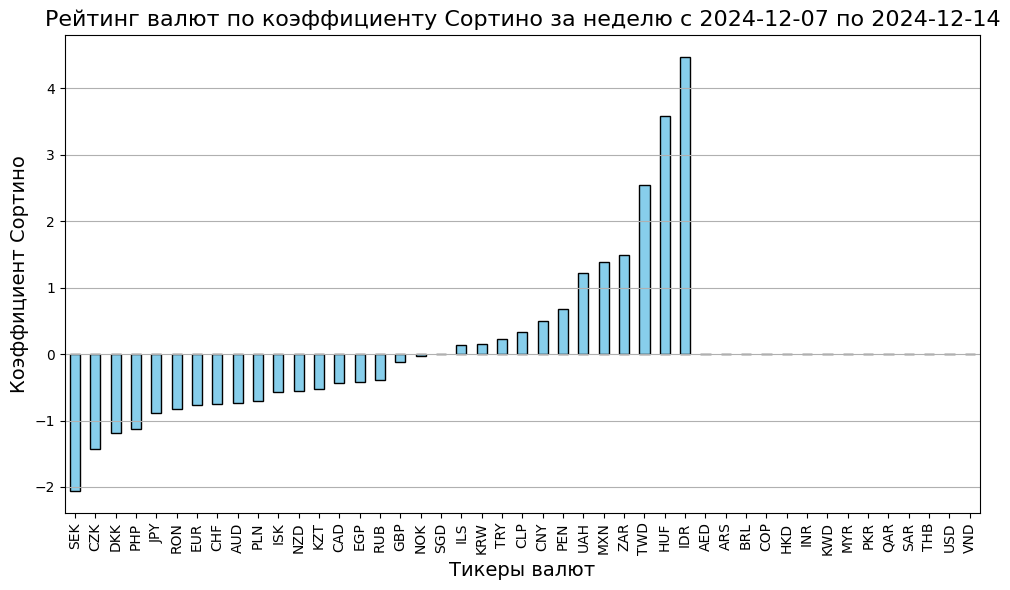

## За месяц (по коэффициенту Сортино)

Период: с 2024-11-14 по 2024-12-14.

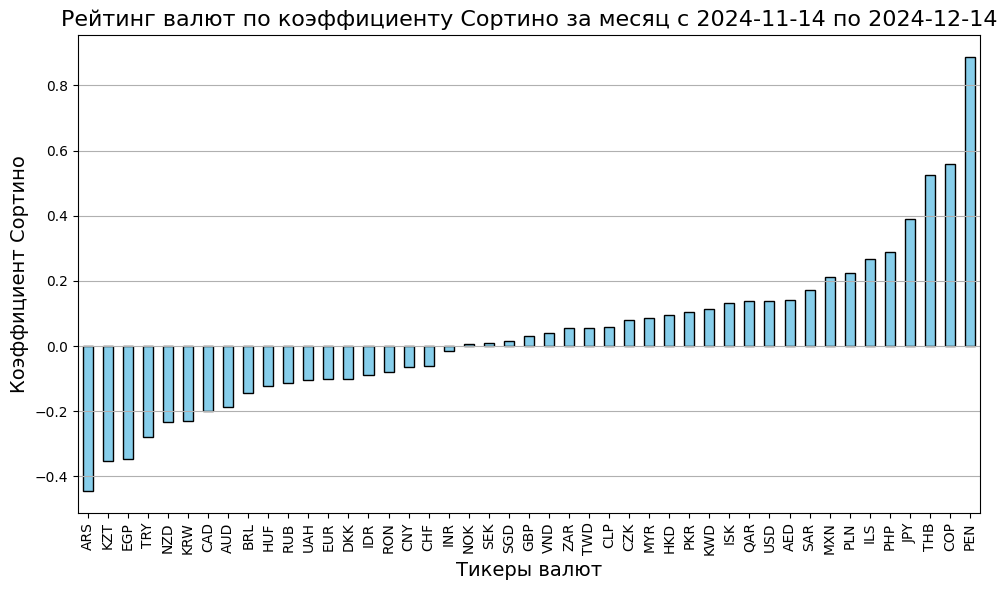

## За квартал (по коэффициенту Сортино)

Период: с 2024-09-14 по 2024-12-14.

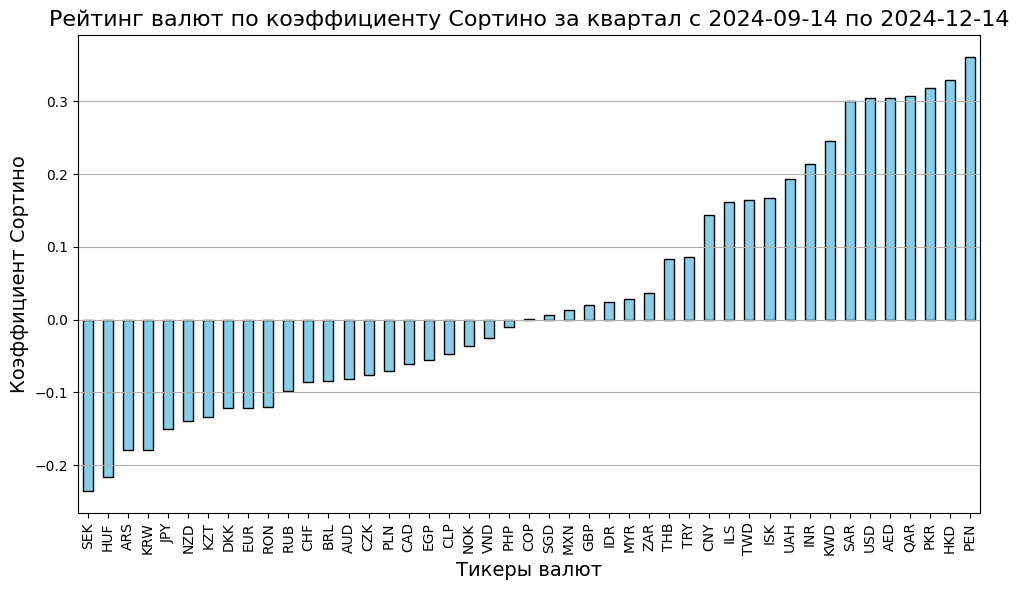

## За полгода (по коэффициенту Сортино)

Период: с 2024-06-14 по 2024-12-14.

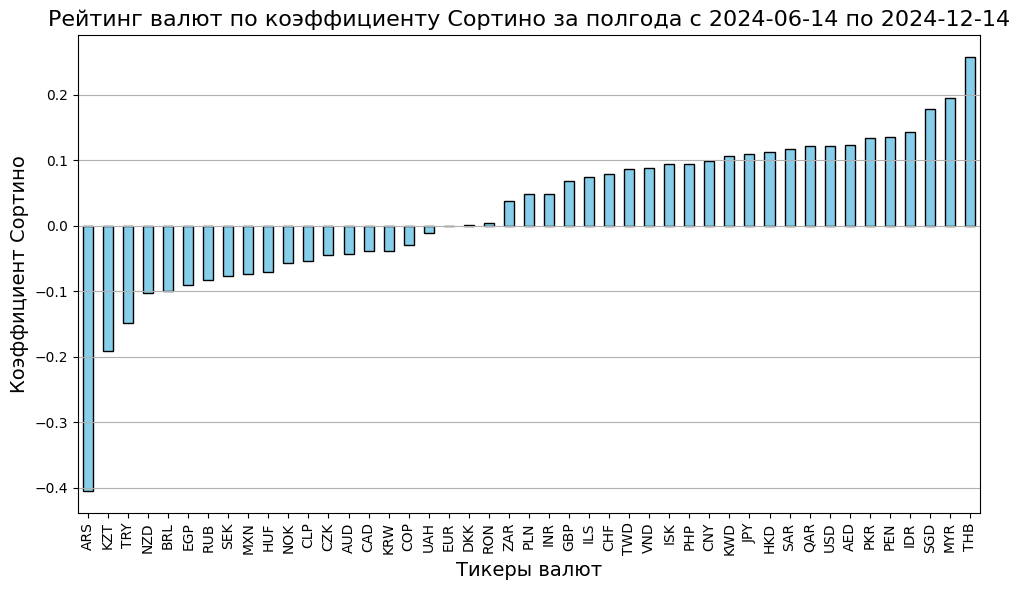

## За год (по коэффициенту Сортино)

Период: с 2023-12-14 по 2024-12-14.

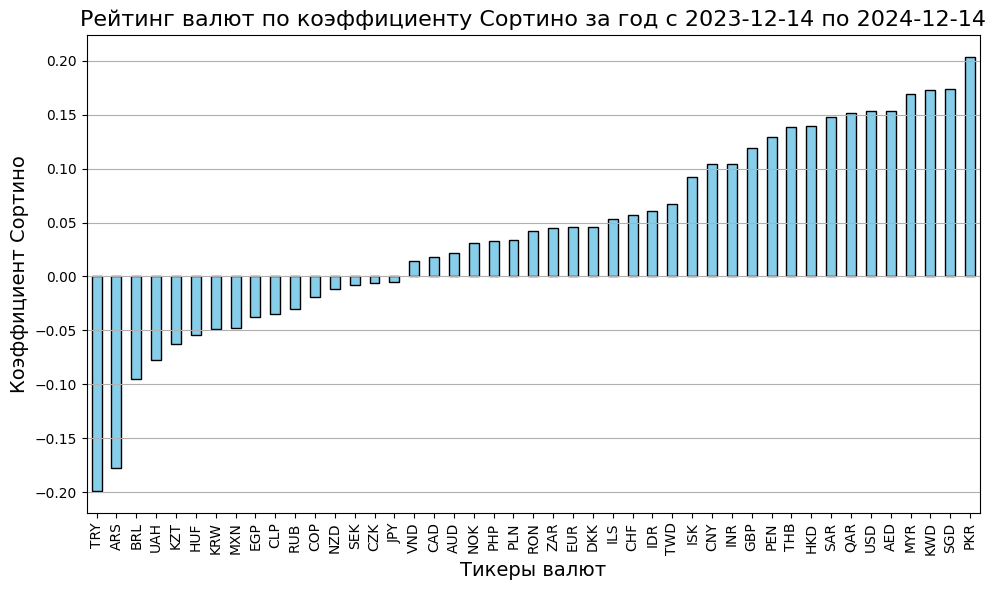

## За два года (по коэффициенту Сортино)

Период: с 2022-12-14 по 2024-12-14.

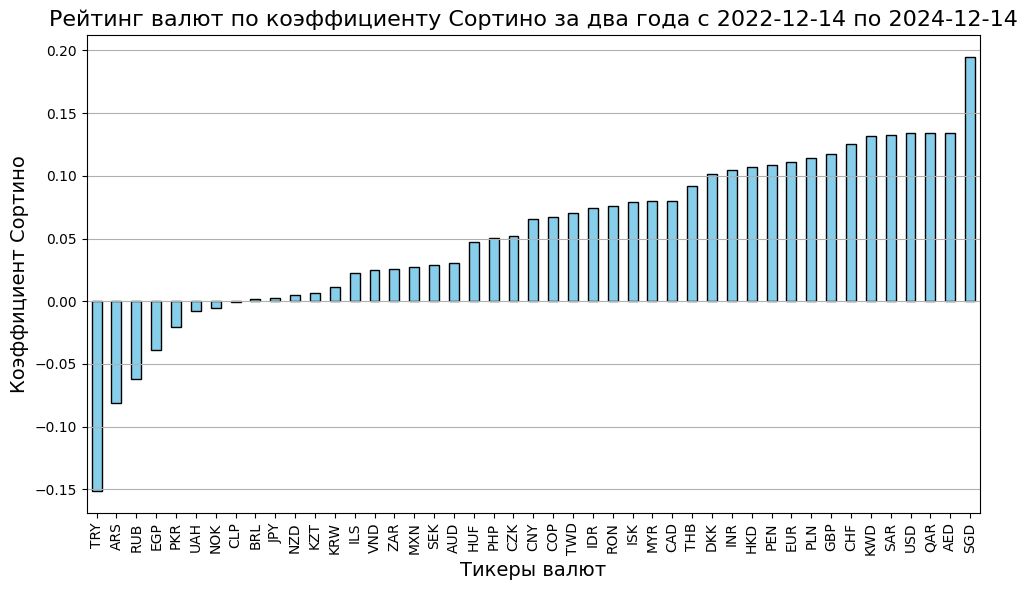

## За три года (по коэффициенту Сортино)

Период: с 2021-12-14 по 2024-12-14.

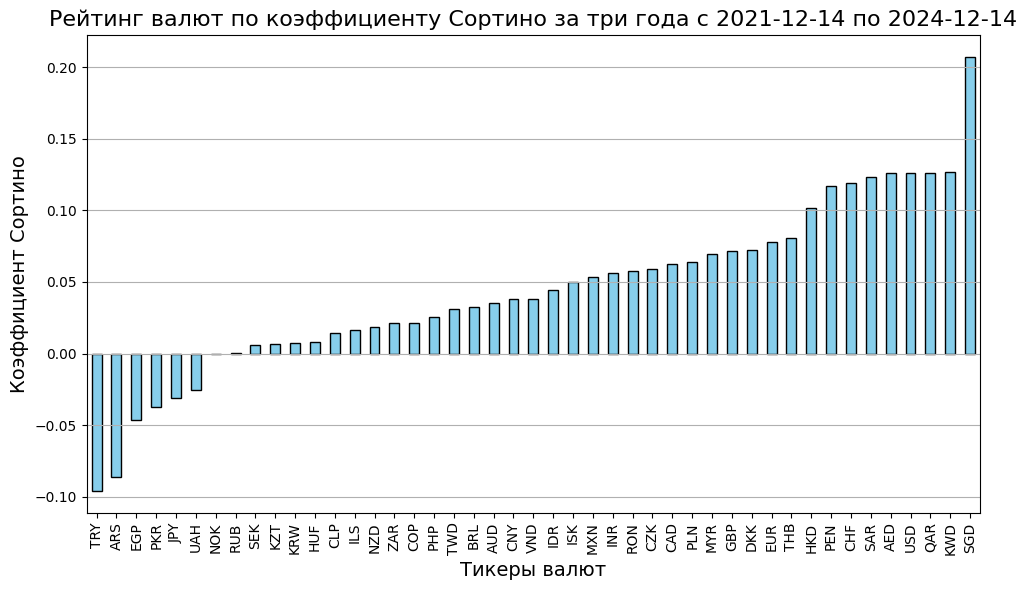

## За пять лет (по коэффициенту Сортино)

Период: с 2019-12-14 по 2024-12-14.

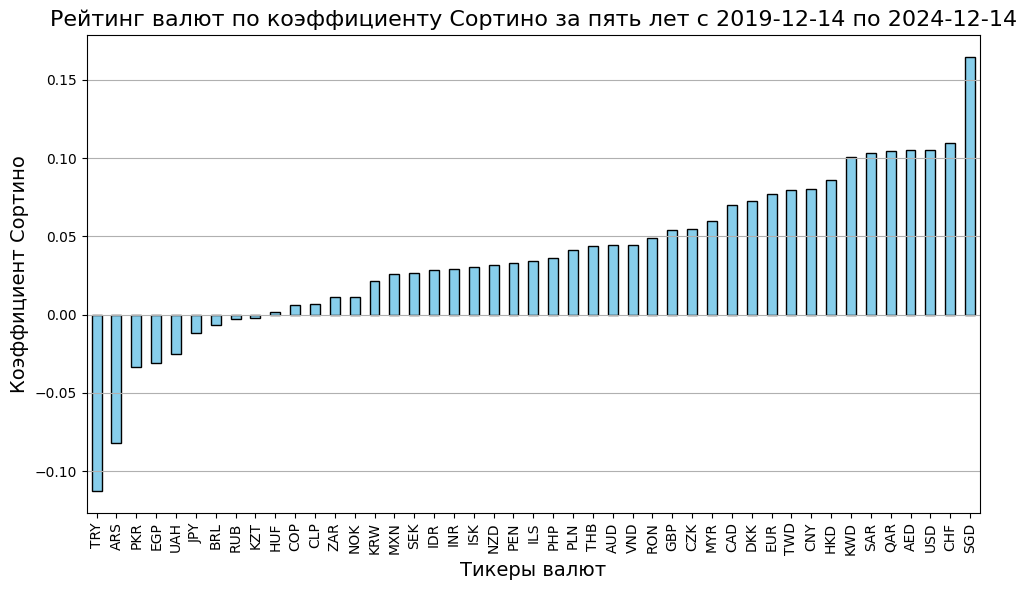

## За десять лет (по коэффициенту Сортино)

Период: с 2014-12-14 по 2024-12-14.

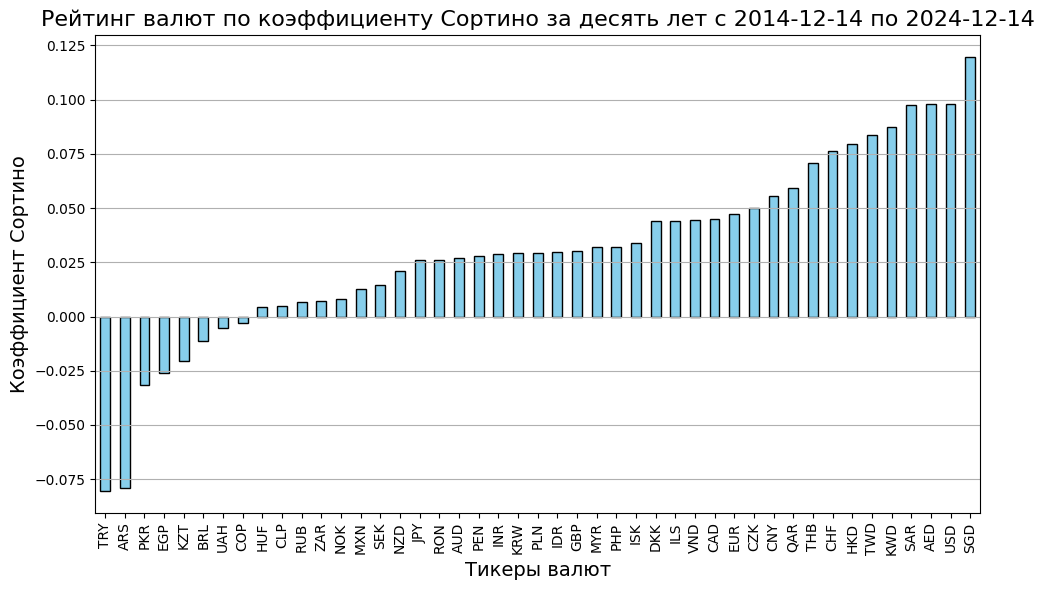

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

# Проверка результата
for period, series in sortino_series.items():
    sorted_series = series.sort_values()  # Сортируем значения по возрастанию

    # Вывод заголовка периода
    display(Markdown(f'## За {period} (по коэффициенту Сортино)'))
    
    # Вывод диапазона дат
    start_date = ago_dates[period]
    display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
    # Получаем 10 наиболее наиболее и наименее выгодных по коэффициенту Сортино тикеров
    top_gainers = sorted_series.nlargest(10)
    top_losers = sorted_series.nsmallest(10)

    # Формируем один абзац текста для топ-10 наиболее выгодных по коэффициенту Сортино валют
    gainers_text = "Топ 10 наиболее выгодных по коэффициенту Сортино валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_gainers.items()]
    )

    # Формируем один абзац текста для топ-10 наименее выгодных по коэффициенту Шарпа валют
    losers_text = "Топ 10 наименее выгодных по коэффициенту Сортино валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_losers.items()]
    )

    # Выводим текст с гиперссылками
    display(HTML(gainers_text))
    display(HTML(losers_text))
    
    plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
    sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Рейтинг валют по коэффициенту Сортино за {period} с {start_date.date()} по {today.date()}', fontsize=16)
    plt.xlabel('Тикеры валют', fontsize=14)
    plt.ylabel('Коэффициент Сортино', fontsize=14)

    plt.grid(axis='y')  # Добавляем сетку по оси Y

    plt.tight_layout()  # Автоматически подгоняем параметры графика
    
    plt.show()  # Отображаем график